In [1]:
import mxnet as mx
from mxnet import gluon
from mxnet.gluon import nn

D:\python\Anaconda3\lib\site-packages\urllib3\contrib\pyopenssl.py:46: DeprecationWarning: OpenSSL.rand is deprecated - you should use os.urandom instead
  import OpenSSL.SSL


In [2]:
num_epochs = 10
batch_size = 64
learning_rate = 1e-3
ctx = mx.gpu()

In [3]:
def transform(data,label):
    return (data.astype('float32') / 255 - 0.5) / 0.5 ,label.astype('float32')

In [4]:
mnist_train=gluon.data.vision.MNIST(train=True,transform=transform)

In [5]:
dataloader = gluon.data.DataLoader(
    mnist_train, batch_size=batch_size, shuffle=True)

In [6]:
class autoencoder(gluon.HybridBlock):
    def __init__(self):
        super(autoencoder,self).__init__()
        
        self.encoder=gluon.nn.HybridSequential('encoder_')
        with self.encoder.name_scope():
            self.encoder.add(
                nn.Dense(128,activation='relu'),
                nn.Dense(64,activation='relu'),
                nn.Dense(32,activation='relu'),
            )
            
        self.decoder=gluon.nn.HybridSequential('decoder_')
        with self.decoder.name_scope():
            self.encoder.add(
                nn.Dense(32,activation='relu'),
                nn.Dense(64,activation='relu'),
                nn.Dense(128,activation='relu'),
                nn.Dense(28*28,activation=None)
            )
        
    def hybrid_forward(self, F, x):
        x=self.encoder(x)
        x=F.tanh(self.decoder(x))
        return x
        

In [8]:
model=autoencoder()
model

autoencoder(
  (encoder): HybridSequential(
    (0): Dense(None -> 128, Activation(relu))
    (1): Dense(None -> 64, Activation(relu))
    (2): Dense(None -> 32, Activation(relu))
    (3): Dense(None -> 32, Activation(relu))
    (4): Dense(None -> 64, Activation(relu))
    (5): Dense(None -> 128, Activation(relu))
    (6): Dense(None -> 784, linear)
  )
  (decoder): HybridSequential(
  
  )
)

## 网络可视化

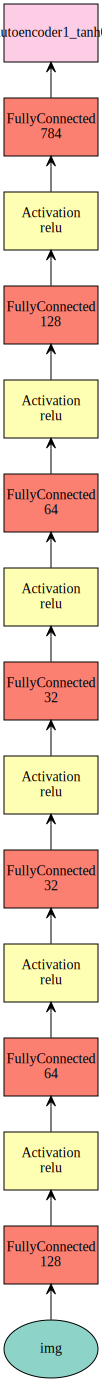

In [9]:
import mxnet as mx
block=model
mx.viz.plot_network(block(mx.sym.var("img")))

In [20]:
model.collect_params().initialize(mx.init.Xavier(),ctx=ctx)
l2loss=gluon.loss.L2Loss()
trainer=gluon.Trainer(model.collect_params(),'adam',{
    'learning_rate':learning_rate,'wd':1e-5})

In [24]:
for epoch in range(num_epochs):
    running_loss = 0.0
    n_total = 0.0
    for data in dataloader:
        img, _ = data
        img = img.reshape((img.shape[0], -1)).as_in_context(ctx)

        with mx.autograd.record():
            output = model(img)
            loss = l2loss(output, img)
        loss.backward()
        trainer.step(img.shape[0])
        running_loss += mx.nd.sum(loss).asscalar()
        n_total += img.shape[0]
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, num_epochs, running_loss / n_total))

epoch [1/10], loss:0.0378
epoch [2/10], loss:0.0328
epoch [3/10], loss:0.0295
epoch [4/10], loss:0.0275
epoch [5/10], loss:0.0259
epoch [6/10], loss:0.0245
epoch [7/10], loss:0.0236
epoch [8/10], loss:0.0229
epoch [9/10], loss:0.0224
epoch [10/10], loss:0.0220
